<a href="https://colab.research.google.com/github/dbenayoun/Generative-AI-Module-Dauphine/blob/main/importGolois_DavidBenayoun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learnig Project

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Models/David_Benayoun_0.4.h5')

log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Models/log.csv')

In [1]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2022.zip
!unzip project2022.zip

--2024-07-30 17:42:20--  https://www.lamsade.dauphine.fr/~cazenave/project2022.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138884468 (132M) [application/zip]
Saving to: ‘project2022.zip’

project2022.zip     100%[===================>] 132.45M  14.2MB/s    in 10s     

2024-07-30 17:42:31 (13.1 MB/s) - ‘project2022.zip’ saved [138884468/138884468]

Archive:  project2022.zip
  inflating: Board.h                 
  inflating: Game.h                  
  inflating: Rzone.h                 
  inflating: compile.sh              
  inflating: compileMAC.sh           
  inflating: games.data              
  inflating: golois.cpp              
  inflating: golois.cpython-310-x86_64-linux-gnu.so  
  inflating: golois.cpython-37m-x86_64-linux-gnu.so  
  inflating: golois.cpython-38-x86_64-linux-gnu.so  
  inflat

In [2]:
!python golois.py

2024-07-30 17:42:48.970648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 17:42:48.970697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 17:42:48.972043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 17:42:48.979974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 17:42:49.946730: W tensorflow/comp

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc
import pandas as pd
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt


In [5]:
import golois

ModuleNotFoundError: No module named 'golois'

In [10]:
planes = 31
moves = 361
N = 10000
epochs = 100
batch = 128
filters = 32

In [11]:
input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)

getValidation


## Convolutional Neural Network for Board Game Strategy

This code defines a Convolutional Neural Network (CNN) model for predicting both the policy (next move) and value (winning probability) for a given board state in a strategy game. The model utilizes advanced techniques such as Squeeze-and-Excitation (SE) blocks and ConvNeXt blocks for enhanced feature extraction and learning efficiency. Here's a detailed explanation of each component:

### Squeeze-and-Excitation Block
The Squeeze-and-Excitation block is designed to improve the representational power of the network by explicitly modeling the interdependencies between the channels of convolutional features. It performs the following steps:
1. **Global Average Pooling**: Reduces each channel to a single value, summarizing the global information.
2. **Fully Connected Layers**: First reduces and then restores the number of channels, applying activation functions to introduce non-linearity.
3. **Reshape and Multiply**: Reshapes the output to match the input dimensions and scales the input features accordingly.

### ConvNeXt Block
The ConvNeXt block is an advanced convolutional block that consists of:
1. **Depthwise Convolution**: Applies a depthwise convolution to each input channel separately.
2. **Batch Normalization**: Normalizes the output to accelerate training and improve performance.
3. **Pointwise Convolutions**: Uses 1x1 convolutions to expand and then compress the feature dimensions, with a non-linear activation in between.
4. **Squeeze-and-Excitation Block**: Integrates the SE block for channel-wise attention.
5. **Skip Connection**: Adds the input of the block to the output (residual connection), which helps in training deep networks.

### Model Architecture
1. **Input Layer**: Takes a 19x19x(planes) board state as input.
2. **Initial Convolution and Batch Normalization**: Applies an initial convolution followed by batch normalization.
3. **ConvNeXt Blocks**: Stacks 8 ConvNeXt blocks for deep feature extraction.
4. **Policy Head**:
   - Convolution, Batch Normalization, and Flatten layers.
   - Ends with a softmax activation function to output probabilities for each possible move.
5. **Value Head**:
   - Convolution, Batch Normalization, and Flatten layers.
   - Followed by a dense layer with ReLU activation and dropout for regularization.
   - Ends with a sigmoid activation function to output the probability of winning.


In [12]:
# Define the Squeeze-and-Excitation block
def squeeze_excite_block(inputs, ratio=16):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Reshape([1, 1, filters])(se)
    x = layers.multiply([inputs, se])
    return x

def convnext_block(x, blocks):
  for i in range (blocks):
    x1 = layers.DepthwiseConv2D((7,7), padding='same', use_bias = False)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(4 * filters, 1, padding='same', activation='swish')(x1)
    x1 = layers.Conv2D(filters, 1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = squeeze_excite_block(x1)
    x = layers.add([x1,x])
  x = tf.keras.layers.BatchNormalization()(x)
  return x

input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)
x = layers.BatchNormalization()(x)

x = convnext_block(x, 8)

# Policy head
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.BatchNormalization()(policy_head)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

# Value head
value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.BatchNormalization()(value_head)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dropout(0.5)(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])



Check the count of parameters

In [13]:
print('Count of parameters: ', model.count_params())

Count of parameters:  101935


## Learning Rate

In [14]:
def step_decay(epoch):
    initial_lr = 0.0005
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))
    return lr

def cosine_decay(epoch, initial_lr):
    max_epochs = 500
    min_lr = 0.0001
    lr = min_lr + (initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / max_epochs)) / 2
    #print("Learning rate for epoch {}: {}".format(epoch, lr))
    return lr



# Compile

In [16]:
lr = 0.0005
epochs = 300

lr_scheduler = LearningRateScheduler(cosine_decay)

model.compile(optimizer=keras.optimizers.Adam(lr),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 1.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

log = {'Epoch': [], 'Loss': [], 'Policy_loss': [], 'Value_loss': [], 'Policy_acc': [], 'Value_mse': [], 'lr': []}

for i in range (1, epochs + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        epochs=1, batch_size=batch
                        ,callbacks=[lr_scheduler]
                        )
    #save log
    log['Epoch'].append (i)
    log['Loss'].append (history.history['loss'][0])
    log['Policy_loss'].append (history.history['policy_loss'][0])
    log['Value_loss'].append (history.history['value_loss'][0])
    log['Policy_acc'].append (history.history['policy_categorical_accuracy'][0])
    log['Value_mse'].append (history.history['value_mse'][0])
    log['lr'].append (history.history['lr'][0])

    #save log in Drive
    df = pd.DataFrame(log)
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/Models/log.csv', index=False)

    if (i % 5 == 0):
        gc.collect ()
    if (i % epochs == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        print ("val =", val)
        model.save ('/content/drive/MyDrive/Colab Notebooks/Models/test.h5')


epoch 1
79/79 [==============================] - 27s 73ms/step - loss: 6.2721 - policy_loss: 5.4752 - value_loss: 0.7877 - policy_categorical_accuracy: 0.0219 - value_mse: 0.1505 - lr: 5.0000e-04
epoch 2
79/79 [==============================] - 5s 67ms/step - loss: 5.2823 - policy_loss: 4.5735 - value_loss: 0.6998 - policy_categorical_accuracy: 0.0872 - value_mse: 0.1225 - lr: 5.0000e-04
epoch 3
79/79 [==============================] - 5s 68ms/step - loss: 4.9644 - policy_loss: 4.2598 - value_loss: 0.6957 - policy_categorical_accuracy: 0.1223 - value_mse: 0.1216 - lr: 5.0000e-04
epoch 4
79/79 [==============================] - 6s 71ms/step - loss: 4.6876 - policy_loss: 3.9827 - value_loss: 0.6962 - policy_categorical_accuracy: 0.1738 - value_mse: 0.1219 - lr: 5.0000e-04
epoch 5
79/79 [==============================] - 5s 66ms/step - loss: 4.5927 - policy_loss: 3.8903 - value_loss: 0.6938 - policy_categorical_accuracy: 0.1850 - value_mse: 0.1198 - lr: 5.0000e-04
epoch 6
79/79 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Visualization and Performance anlysis

1. Overall Loss
Plotting the overall loss over epochs helps to understand how well the model is fitting the training data.

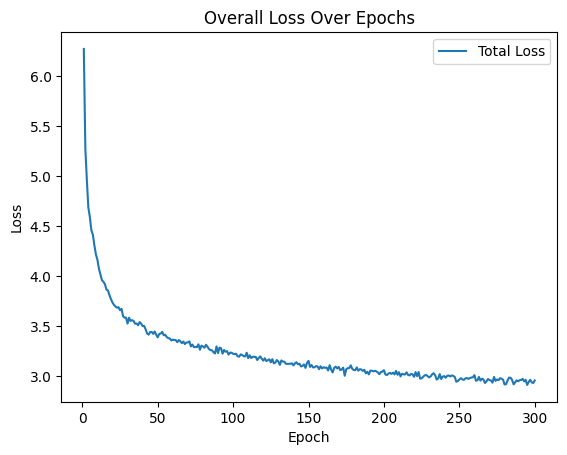

In [11]:
plt.plot(log['Epoch'], log['Loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Overall Loss Over Epochs')
plt.legend()
plt.show()


2. Policy and Value Loss
Plotting the policy and value losses separately can provide insights into how each part of the model is learning.

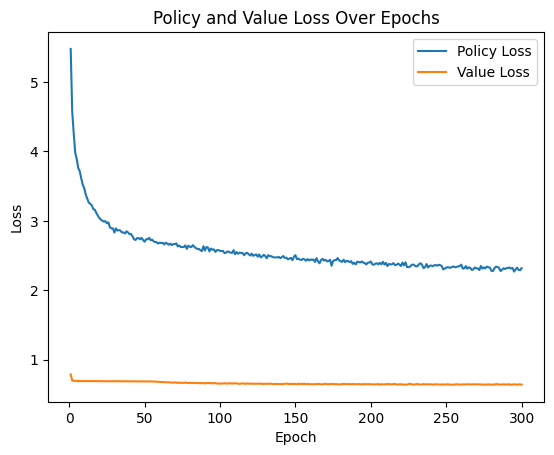

In [12]:
plt.plot(log['Epoch'], log['Policy_loss'], label='Policy Loss')
plt.plot(log['Epoch'], log['Value_loss'], label='Value Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Policy and Value Loss Over Epochs')
plt.legend()
plt.show()

3. Policy Accuracy
Plotting the policy accuracy over epochs helps to understand how well the model is predicting the next moves.

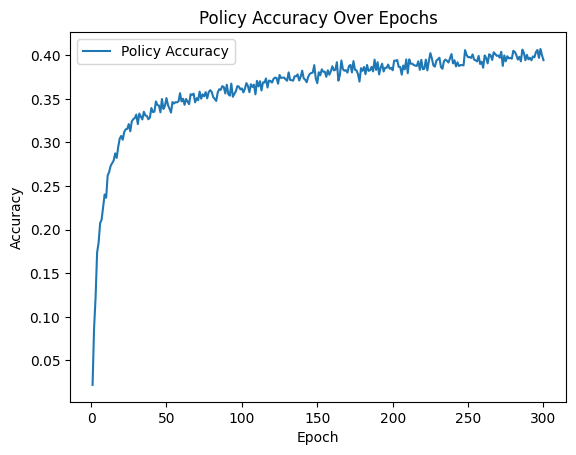

In [13]:
plt.plot(log['Epoch'], log['Policy_acc'], label='Policy Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Policy Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
#model.save('test_{0}.h5'.format(round(val[3],2)))
model.save('/content/drive/MyDrive/Colab Notebooks/Models/David_Benayoun.h5', save_format="h5")
